In [58]:
# ======================================================
# MOVIE RATING PREDICTION – CODSOFT TASK 2
# ======================================================

# -------------------------------
# 1. Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print("Libraries Loaded Successfully.")


Libraries Loaded Successfully.


In [59]:
# -------------------------------
# 2. Load Dataset
# -------------------------------
df = pd.read_csv("/content/IMDb Movies India.csv", encoding='latin1')
print("Dataset Loaded Successfully.")
df.head()


Dataset Loaded Successfully.


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [60]:
# ======================================================
# 3. Data Cleaning
# ======================================================

# Remove rows where Rating is missing
df = df.dropna(subset=["Rating"])

# Remove duplicates
df = df.drop_duplicates()

# ---- CLEAN YEAR ----
df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# ---- CLEAN DURATION ----
df["Duration"] = df["Duration"].astype(str).str.extract(r"(\d+)")
df["Duration"] = pd.to_numeric(df["Duration"], errors="coerce")

# ---- CLEAN VOTES ----
df["Votes"] = df["Votes"].astype(str).str.replace(",", "", regex=True)
df["Votes"] = pd.to_numeric(df["Votes"], errors="coerce")

# ---- Fill missing categorical values ----
cat_cols = ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

# ---- FINAL DROP invalid numeric rows ----
df = df.dropna(subset=["Year", "Duration", "Votes"])

print("Data Cleaning Completed.")
df.head()


Data Cleaning Completed.


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


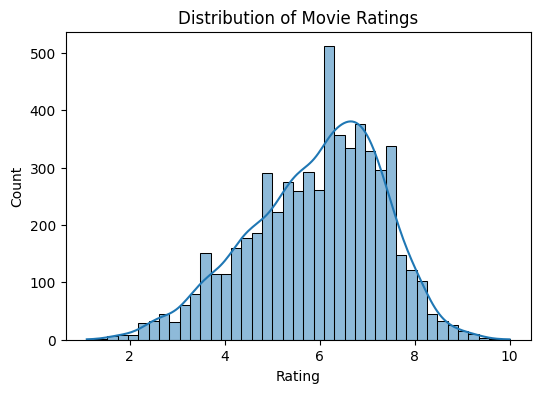

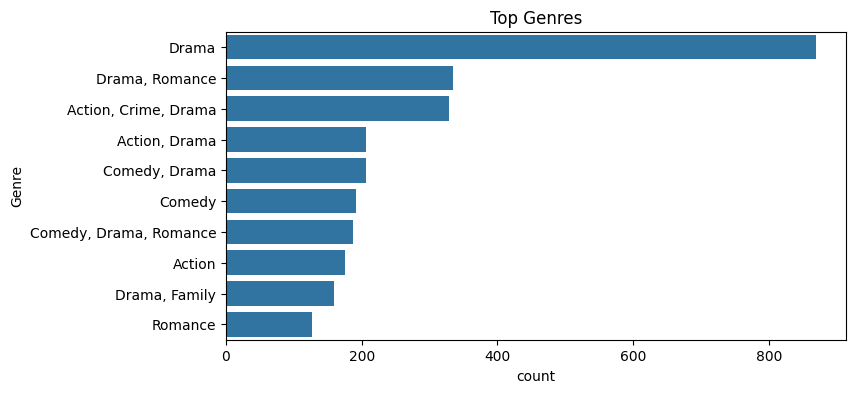

In [61]:
# -------------------------------
# 4. Exploratory Data Analysis
# -------------------------------

plt.figure(figsize=(6,4))
sns.histplot(df["Rating"], kde=True)
plt.title("Distribution of Movie Ratings")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(y=df["Genre"], order=df["Genre"].value_counts().head(10).index)
plt.title("Top Genres")
plt.show()


In [62]:
# -------------------------------
# 5. Feature Selection
# -------------------------------
X = df[["Year", "Duration", "Votes", "Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]]
y = df["Rating"]

categorical_cols = ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]
numeric_cols = ["Year", "Duration", "Votes"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

print("Feature Selection Completed.")


Feature Selection Completed.


In [63]:
# -------------------------------
# 6. Train–Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training Size:", X_train.shape)
print("Testing Size :", X_test.shape)


Training Size: (4680, 8)
Testing Size : (1171, 8)


In [64]:
# ======================================================
# 7. Build & Train Models
# ======================================================

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

X_train_small = X_train[:20000]
y_train_small = y_train[:20000]

print("Training on:", len(X_train_small), "rows")

lr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SGDRegressor(max_iter=2000, random_state=42))
])

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=80,
        max_depth=15,
        random_state=42
    ))
])

# Train
lr_model.fit(X_train_small, y_train_small)
rf_model.fit(X_train_small, y_train_small)

print("Models Trained Successfully ✔️")


Training on: 4680 rows
Models Trained Successfully ✔️


In [65]:
# -------------------------------
# 8. Evaluate Models
# -------------------------------
def evaluate(model, name):
    pred = model.predict(X_test)
    print("\n===== {} =====".format(name))
    print("MAE  :", mean_absolute_error(y_test, pred))
    print("RMSE :", np.sqrt(mean_squared_error(y_test, pred)))
    print("R²   :", r2_score(y_test, pred))

evaluate(lr_model, "Linear Regression")
evaluate(rf_model, "Random Forest Regressor")




===== Linear Regression =====
MAE  : 1.9932427149815936e+16
RMSE : 9.986103628276374e+16
R²   : -5.359923884231728e+33

===== Random Forest Regressor =====
MAE  : 0.8456481440125934
RMSE : 1.1344533238767853
R²   : 0.30826500203705165


In [68]:
# =====================================================
# 9. MOVIE RATING PREDICTION
# =====================================================

print("\n--- ENTER MOVIE DETAILS FOR PREDICTION ---\n")

year = int(input("Enter Year: "))
duration = int(input("Enter Duration (minutes): "))
votes = int(input("Enter Votes: "))

genre = input("Enter Genre: ")
director = input("Enter Director Name: ")
actor1 = input("Enter Actor 1: ")
actor2 = input("Enter Actor 2: ")
actor3 = input("Enter Actor 3: ")

# Create dataframe
user_input = pd.DataFrame({
    "Year": [year],
    "Duration": [duration],
    "Votes": [votes],
    "Genre": [genre],
    "Director": [director],
    "Actor 1": [actor1],
    "Actor 2": [actor2],
    "Actor 3": [actor3]
})

# Predict using Random Forest

final_pred = rf_model.predict(user_input)[0]
print("\nPredicted Movie Rating:", round(final_pred, 2))



--- ENTER MOVIE DETAILS FOR PREDICTION ---

Enter Year: 2023
Enter Duration (minutes): 120
Enter Votes: 85000
Enter Genre: Action
Enter Director Name: Atlee
Enter Actor 1: Vijay
Enter Actor 2: Nayanthara
Enter Actor 3: S.J.Suryah

Predicted Movie Rating: 7.49
